# Aim: Predict Rating from Review using basic and deep models

- keras-
- mlp
- lstm
- cnn

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import itertools

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import six
from abc import ABCMeta
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!pip install easycolab
import easycolab as ec
ec.mount()
ec.openmydrive()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def review_to_wordlist( review, remove_stopwords=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()

    #
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (True by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    b=[]
    stemmer = english_stemmer #PorterStemmer()
    for word in words:
        b.append(stemmer.stem(word))

    # 5. Return a list of words
    return(b)

In [0]:
data_file = 'Amazon_Unlocked_Mobile.csv'

n = 413000  
s = 20000 
skip = sorted(random.sample(range(1,n),n-s))


data = pd.read_csv( data_file, delimiter = ",", skiprows = skip)

In [0]:
data.shape

(20840, 6)

In [0]:
data.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.00,5,I've been a long time user of the iPhone. I fi...,2.0
1,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.00,5,Ver Good!,0.0
2,"(LANDVO) 5.0"" Capacitive Touch MTK6582 Quad Co...",HTM,69.99,5,phone works great for the price although when ...,1.0
3,[XMAS DEAL] [New Edition] Jethro [SC213V2] Fli...,Jethro,79.99,5,Bought for my mom! She loves it!,8.0
4,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,5,Great phone!,0.0
5,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,5,Great simple to use phone for my mother. Big b...,1.0
6,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,4,I bought it for my mom who is in her late 70s ...,20.0
7,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,1,Stopped working after a month of use.,0.0
8,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,2,I bought this phone as a simple option for my ...,0.0
9,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,2,The speakers are garbage and it only tells tim...,0.0


In [0]:
data = data[data['Reviews'].isnull()==False]

In [0]:
train, test = train_test_split(data, test_size = 0.3)

In [0]:
## Labels Exploration

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


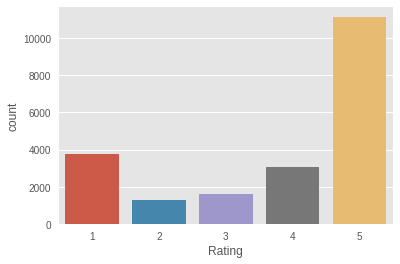

In [0]:
sns.countplot(data['Rating'])

In [0]:
### Apply Preprocessing

In [0]:
clean_train_reviews = []
for review in train['Reviews']:
    clean_train_reviews.append( " ".join(review_to_wordlist(review)))
    
clean_test_reviews = []
for review in test['Reviews']:
    clean_test_reviews.append( " ".join(review_to_wordlist(review)))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.amazon.com/dp/B00YD547Q6/ref=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probab

In [0]:
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 200000, ngram_range = ( 1, 4 ),
                              sublinear_tf = True )

vectorizer = vectorizer.fit(clean_train_reviews)
train_features = vectorizer.transform(clean_train_reviews)

test_features = vectorizer.transform(clean_test_reviews)

In [0]:
fselect = SelectKBest(chi2 , k=10000)
train_features = fselect.fit_transform(train_features, train["Rating"])
test_features = fselect.transform(test_features)

In [0]:
model1 = MultinomialNB(alpha=0.001)
model1.fit( train_features, train["Rating"] )

model2 = SGDClassifier(loss='modified_huber', n_iter=5, random_state=0, shuffle=True)
model2.fit( train_features, train["Rating"] )

model3 = RandomForestClassifier()
model3.fit( train_features, train["Rating"] )

model4 = GradientBoostingClassifier()
model4.fit( train_features, train["Rating"] )

pred_1 = model1.predict( test_features.toarray() )
pred_2 = model2.predict( test_features.toarray() )
pred_3 = model3.predict( test_features.toarray() )
pred_4 = model4.predict( test_features.toarray() )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
class NBSVM(six.with_metaclass(ABCMeta, BaseEstimator, ClassifierMixin)):

    def __init__(self, alpha=1.0, C=1.0, max_iter=10000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.C = C
        self.svm_ = [] # fuggly

    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        _, n_features = X.shape

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        # LabelBinarizer().fit_transform() returns arrays with dtype=np.int64.
        # so we don't have to cast X to floating point
        Y = Y.astype(np.float64)

        # Count raw events from data
        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.ratios_ = np.full((n_effective_classes, n_features), self.alpha,
                                 dtype=np.float64)
        self._compute_ratios(X, Y)

        # flugglyness
        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            svm = LinearSVC(C=self.C, max_iter=self.max_iter)
            Y_i = Y[:,i]
            svm.fit(X_i, Y_i)
            self.svm_.append(svm) 

        return self

    def predict(self, X):
        n_effective_classes = self.class_count_.shape[0]
        n_examples = X.shape[0]

        D = np.zeros((n_effective_classes, n_examples))

        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            D[i] = self.svm_[i].decision_function(X_i)
        
        return self.classes_[np.argmax(D, axis=0)]
        
    def _compute_ratios(self, X, Y):
        """Count feature occurrences and compute ratios."""
        if np.any((X.data if issparse(X) else X) < 0):
            raise ValueError("Input X must be non-negative")

        self.ratios_ += safe_sparse_dot(Y.T, X)  # ratio + feature_occurrance_c
        normalize(self.ratios_, norm='l1', axis=1, copy=False)
        row_calc = lambda r: np.log(np.divide(r, (1 - r)))
        self.ratios_ = np.apply_along_axis(row_calc, axis=1, arr=self.ratios_)
        check_array(self.ratios_)
        self.ratios_ = sparse.csr_matrix(self.ratios_)

        #p_c /= np.linalg.norm(p_c, ord=1)
        #ratios[c] = np.log(p_c / (1 - p_c))


def f1_class(pred, truth, class_val):
    n = len(truth)

    truth_class = 0
    pred_class = 0
    tp = 0

    for ii in range(0, n):
        if truth[ii] == class_val:
            truth_class += 1
            if truth[ii] == pred[ii]:
                tp += 1
                pred_class += 1
                continue;
        if pred[ii] == class_val:
            pred_class += 1

    precision = tp / float(pred_class)
    recall = tp / float(truth_class)

    return (2.0 * precision * recall) / (precision + recall)


def semeval_senti_f1(pred, truth, pos=2, neg=0): 

    f1_pos = f1_class(pred, truth, pos)
    f1_neg = f1_class(pred, truth, neg)

    return (f1_pos + f1_neg) / 2.0;


def main(train_file, test_file, ngram=(1, 3)):
    print('loading...')
    train = pd.read_csv(train_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    # to shuffle:
    #train.iloc[np.random.permutation(len(df))]

    test = pd.read_csv(test_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    print('vectorizing...')
    vect = CountVectorizer()
    classifier = NBSVM()

    # create pipeline
    clf = Pipeline([('vect', vect), ('nbsvm', classifier)])
    params = {
        'vect__token_pattern': r"\S+",
        'vect__ngram_range': ngram, 
        'vect__binary': True
    }
    clf.set_params(**params)

    #X_train = vect.fit_transform(train['text'])
    #X_test = vect.transform(test['text'])

    print('fitting...')
    clf.fit(train['text'], train['label'])

    print('classifying...')
    pred = clf.predict(test['text'])
   
    print('testing...')
    acc = accuracy_score(test['label'], pred)
    f1 = semeval_senti_f1(pred, test['label'])
    print('NBSVM: acc=%f, f1=%f' % (acc, f1))

In [0]:
model5 = NBSVM(C=0.01)
model5.fit( train_features, train["Rating"] )

pred_5 = model5.predict( test_features )

In [0]:
print(classification_report(test['Rating'], pred_2, target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.69      0.78      0.73      1112
           2       0.42      0.13      0.19       388
           3       0.40      0.10      0.16       456
           4       0.38      0.19      0.25       907
           5       0.74      0.94      0.83      3389

   micro avg       0.69      0.69      0.69      6252
   macro avg       0.53      0.43      0.43      6252
weighted avg       0.63      0.69      0.64      6252



In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test['Rating'], pred_5)

Confusion matrix, without normalization
[[ 880   20   21   19  172]
 [ 198   42   20   27  101]
 [ 125   12   53   64  202]
 [  51    6   18  141  691]
 [  48    9   15  103 3214]]


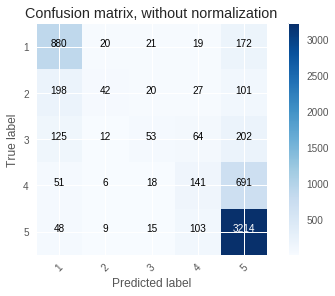

In [0]:
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5'],
                      title='Confusion matrix, without normalization')

In [0]:
print('prediction 1 accuracy: ', accuracy_score(test['Rating'], pred_1))
print('prediction 2 accuracy: ', accuracy_score(test['Rating'], pred_2))
print('prediction 3 accuracy: ', accuracy_score(test['Rating'], pred_3))
print('prediction 4 accuracy: ', accuracy_score(test['Rating'], pred_4))
print('prediction 5 accuracy: ', accuracy_score(test['Rating'], pred_5))

prediction 1 accuracy:  0.6681062060140754
prediction 2 accuracy:  0.6904990403071017
prediction 3 accuracy:  0.663787587971849
prediction 4 accuracy:  0.6541906589891234
prediction 5 accuracy:  0.6925783749200256


In [0]:
batch_size = 32
nb_classes = 5

In [0]:
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 1000, ngram_range = ( 1, 3 ),
                              sublinear_tf = True )

vectorizer = vectorizer.fit(clean_train_reviews)
train_features = vectorizer.transform(clean_train_reviews)

test_features = vectorizer.transform(clean_test_reviews)

In [0]:
X_train = train_features.toarray()
X_test = test_features.toarray()

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(train['Rating']-1)
y_test = np.array(test['Rating']-1)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


# pre-processing: divide by max and substract mean
scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.mean(X_train)
X_train -= mean
X_test -= mean

input_dim = X_train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(256, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Training...")
model.fit(X_train, Y_train, nb_epoch=5, batch_size=16, validation_split=0.1)






print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

X_train shape: (14585, 1000)
X_test shape: (6252, 1000)
Training...
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 13126 samples, validate on 1459 samples
Epoch 1/5
13126/13126 [==============================] - 7s 516us/step - loss: 0.9833 - acc: 0.6406 - val_loss: 0.8947 - val_acc: 0.6635
Epoch 2/5
13126/13126 [==============================] - 6s 437us/step - loss: 0.8645 - acc: 0.6861 - val_loss: 0.8988 - val_acc: 0.6690
Epoch 3/5
13126/13126 [==============================] - 6s 438us/step - loss: 0.8229 - acc: 0.7000 - val_loss: 0.8940 - val_acc: 0.6731
Epoch 4/5
13126/13126 [==============================] - 6s 438us/step - loss: 0.7998 - acc: 0.7183 - val_loss: 0.9074 - val_acc: 0.6669
Epoch 5/5
13126/13126 [==============================] - 6s 427us/step - loss: 0.7743 - acc: 0.7239 - val_loss: 0.9138 - val_acc: 0.6669
Generating test predictions...


In [0]:
print('prediction 7 accuracy: ', accuracy_score(test['Rating'], preds+1))

prediction 7 accuracy:  0.6805822136916186


### LSTM

In [0]:
max_features = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
maxlen = 80
batch_size = 32
nb_classes = 5

In [0]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=max_features)
tokenizer.fit_on_texts(train['Reviews'])
sequences_train = tokenizer.texts_to_sequences(train['Reviews'])
sequences_test = tokenizer.texts_to_sequences(test['Reviews'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [0]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (14585, 80)
X_test shape: (6252, 80)


In [0]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

Build model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.


Train...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 14585 samples, validate on 6252 samples
Epoch 1/1
6252/6252 [==============================] - 8s 1ms/step
Test score: 0.2906438502568277
Test accuracy: 0.886148420992526
Generating test predictions...


In [0]:
print('prediction 7 accuracy: ', accuracy_score(test['Rating'], preds+1))

prediction 7 accuracy:  0.6820217530390275


In [0]:
### CNN

In [0]:
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 2

In [0]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))

def max_1d(X):
    return K.max(X, axis=1)

model.add(Lambda(max_1d, output_shape=(nb_filter,)))
model.add(Dense(hidden_dims)) 
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=250, kernel_size=3, strides=1, padding="valid")`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

Train...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 14585 samples, validate on 6252 samples
Epoch 1/1
6252/6252 [==============================] - 3s 472us/step
Test score: 0.28053035273890575
Test accuracy: 0.8865322978620108
Generating test predictions...


In [0]:
print('prediction 8 accuracy: ', accuracy_score(test['Rating'], preds+1))

prediction 8 accuracy:  0.6882597568777991


In [0]:
preds

array([0, 4, 0, ..., 0, 4, 4])